<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Available-datasets" data-toc-modified-id="Available-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Available datasets</a></span><ul class="toc-item"><li><span><a href="#Utils-for-departments/regions-codes" data-toc-modified-id="Utils-for-departments/regions-codes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Utils for departments/regions codes</a></span></li><li><span><a href="#Polygon-dataset" data-toc-modified-id="Polygon-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Polygon dataset</a></span></li><li><span><a href="#Chiffres-cles-dataset" data-toc-modified-id="Chiffres-cles-dataset-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Chiffres cles dataset</a></span></li><li><span><a href="#Other-dataset-same-format-chiffres-cles" data-toc-modified-id="Other-dataset-same-format-chiffres-cles-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Other dataset same format chiffres cles</a></span></li><li><span><a href="#SOS-medecins" data-toc-modified-id="SOS-medecins-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>SOS medecins</a></span></li><li><span><a href="#Testing-dataset" data-toc-modified-id="Testing-dataset-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Testing dataset</a></span></li></ul></li><li><span><a href="#Preliminary-studies" data-toc-modified-id="Preliminary-studies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preliminary studies</a></span></li><li><span><a href="#Learning-task" data-toc-modified-id="Learning-task-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Learning task</a></span></li></ul></div>

In [167]:
from importlib import reload
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import utils_covid
from utils_covid import *
from GP_models import GP_classic as GP_naive
from GP_models import GP_sig_precomputed as GP_sig
import experiments
from experiments import * 
import signature_features_covid
from signature_features_covid import *
#import geojson
import geopandas as gpd
import shapely
import json
from shapely.geometry import Polygon
import geojson
import wget

# Available datasets

## Utils for departments/regions codes

In [5]:
data_covid = pd.read_csv('https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv')
departements = pd.read_csv('covid_data/departements-france.csv')

regions_names = data_covid[data_covid.granularite=='region'].maille_nom.unique()

Match departments and regions

In [85]:
names1 = departements.nom_region.unique()
names2 = data_covid[data_covid.granularite=='departement'].maille_nom.unique()

## Polygon dataset

In [343]:
g = gpd.read_file('covid_data/departements-france-polygons/departements-france-polygons-2020-03-27.json')
g.fillna(0., inplace=True)
g['Resuscitation']=g['Beds'].apply(lambda x: x['Resuscitation'])
g['IntensiveCare']=g['Beds'].apply(lambda x: x['IntensiveCare'])
g['Beds']=g['Beds'].apply(lambda x: x['Total'])
#g.head()
#g['Beds'].groupby(g['Province/State']).sum()
#print(g[g['Province/State']=='Auvergne-Rhône-Alpes'].head())
#print(g.columns)

In [344]:
g.groupby('Province/State').sum().sum()

Beds             16742.0
Deaths            2016.0
Recovered         5738.0
Severe           15743.0
Critical          3773.0
Confirmed         9174.0
Resuscitation     5058.0
IntensiveCare    11684.0
dtype: float64

In [345]:
g = gpd.read_file('covid_data/departements-france-polygons/departements-france-polygons-2020-03-15.json')
g.fillna(0., inplace=True)
g['Resuscitation']=g['Beds'].apply(lambda x: x['Resuscitation'])
g['IntensiveCare']=g['Beds'].apply(lambda x: x['IntensiveCare'])
g['Beds']=g['Beds'].apply(lambda x: x['Total'])
#g.head()
#g['Beds'].groupby(g['Province/State']).sum()
#print(g[g['Province/State']=='Auvergne-Rhône-Alpes'].head())
#print(g.columns)

In [346]:
g.groupby('Province/State').sum().sum()

Beds             16386.0
Confirmed         3974.0
Deaths              68.0
Critical            20.0
Severe              21.0
Recovered           10.0
Resuscitation     4962.0
IntensiveCare    11424.0
dtype: float64

/Users/maudlemercier/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


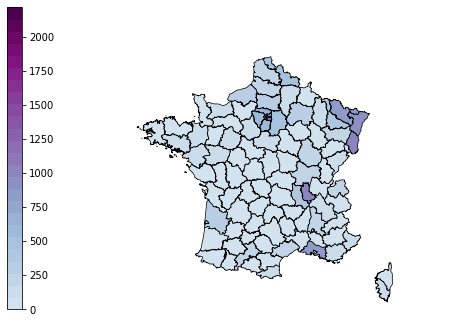

In [336]:
g_df = gpd.GeoDataFrame(pd.DataFrame(g, columns = ['geometry','Province/State','Severe']), geometry = 'geometry')
g_df.crs = {'init': 'epsg:4326'}
g_df=g_df.to_crs("EPSG:3395")

fig,ax = plt.subplots(figsize=(7,7))
fig = ax.get_figure()
cmap1 = matplotlib.cm.BuPu(np.linspace(0,1,30))
cmap2 = matplotlib.colors.ListedColormap(cmap1[5:,:-1])
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=min(g_df.Severe),vmax=max(g_df.Severe)))
sm._A = []
cbaxes = fig.add_axes([0., 0.25, 0.03, 0.60])  # This is the position for the colorbar
cb = plt.colorbar(sm, cax = cbaxes)
g_df.plot(column=g_df.Severe,ax=ax,cmap=cmap2,edgecolor='black',linewidth=0.7)
ax.set_xlim([-1*1e6,1.5*1e6])
ax.set_ylim([4.9*1e6,6.7*1e6])
ax.axis('off')
plt.show()

## Chiffres cles dataset

**Understanding the type of data on which we will work**


- `casConfirmes` : total cumulé du nombre de cas confirmés
- `deces` : total cumulé du nombre de décès
- `decesEhpad` : total cumulé du nombre de décès en EHPAD (si indiqué)
- `hospitalises` : nombre de personnes hospitalisées le jour du bulletin
- `reanimation` : nombre de personnes en réanimation le jour du bulletin
- `gueris` : total cumulé du nombre de personnes guéries (sorties de l'hôpital)
- `depistes` : total cumulé du nombre de personnes dépistées (testées par PCR)

The number of deaths in the ephads is still set to zero, and has not been updated

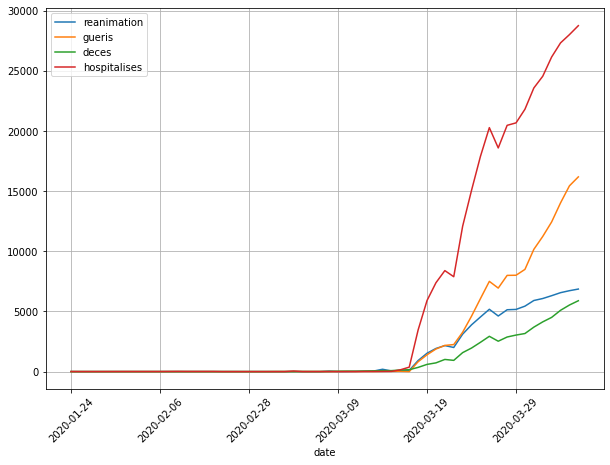

In [295]:
data_covid = pd.read_csv('https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv')
fig,ax = plt.subplots(figsize=(10,7))
data_covid[data_covid.granularite=='region'].groupby('date').sum()[['reanimation','gueris','deces','hospitalises']].plot(rot=45,ax=ax,grid=True)
plt.show()

## Other dataset same format chiffres cles

- `hosp`: Nombre de personnes actuellement hospitalisées
- `rea`:	Nombre de personnes actuellement en réanimation ou soins intensifs
- `rad`:	Nombre cumulé de personnes retournées à domicile
- `dc`: Nombre cumulé de personnes décédées à l'hôpital


The incidence dataset and the cummulative dataset are not consistent

In [76]:
df = pd.read_csv('https://www.data.gouv.fr/en/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7',delimiter=";")
df_incid = pd.read_csv('https://www.data.gouv.fr/en/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c',delimiter=";")

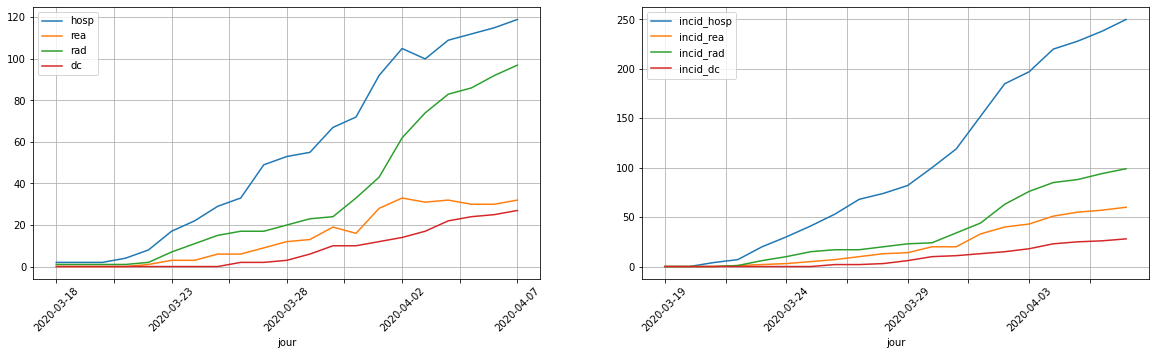

In [79]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
df=df[df['sexe']==0]
df1 = df[df.dep=='01']
df1.groupby(['jour']).sum()[['hosp','rea','rad','dc']].plot(rot=45,ax=ax[0],grid=True)

df_incid1 =df_incid[df_incid.dep=='01']
df_incid1.groupby(['jour']).sum()[['incid_hosp','incid_rea','incid_rad','incid_dc']].cumsum().plot(rot=45,ax=ax[1],grid=True)

plt.show()

In [1]:
# g = df[df.sexe==2].groupby(['dep','jour']).sum()
# g.drop(columns=['sexe'],inplace=True)
# g = g.reset_index(level='dep')
# print(g.head())
# ax = sns.lineplot(x=g.index,y=['hosp','rea'], data=g)

## SOS medecins

The number of emergency room visits for suspicions of coronavirus. Note that in Alpes maritimes there are a lot of visits. However it is not the most touched department. 

In [144]:
df = pd.read_csv('https://static.data.gouv.fr/resources/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/20200407-190011/sursaud-covid19-quotidien-2020-04-07-19h00-departement.csv')
meta_data = pd.read_csv('https://static.data.gouv.fr/resources/donnees-relatives-a-lepidemie-du-covid-19/20200323-194934/metadonnee-urgenceshos-sosmedecin-covid19-quot.csv',delimiter=';')

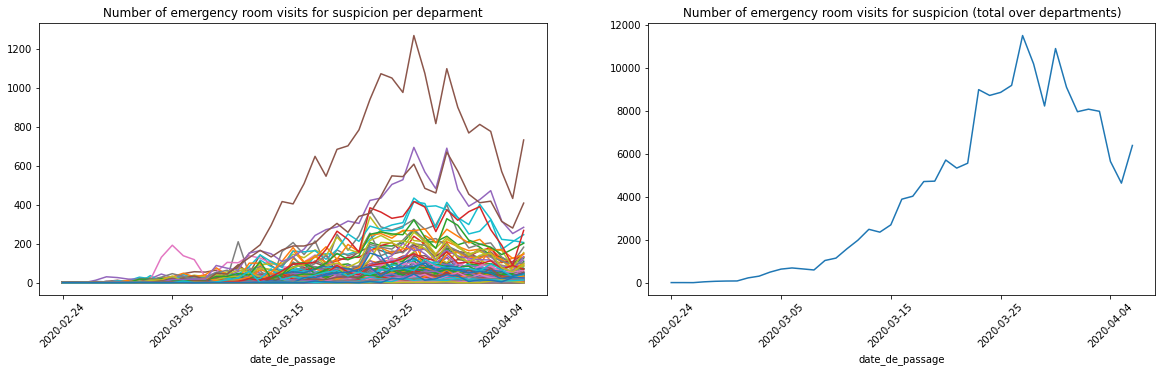

In [143]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
df = df.groupby(['dep','date_de_passage']).sum()
df.unstack(level=0)['nbre_pass_corona'].plot(rot=45,legend=False,ax=ax[0])
ax[0].set_title('Number of emergency room visits for suspicion per deparment')
df.groupby('date_de_passage').sum()['nbre_pass_corona'].plot(rot=45,ax=ax[1])
ax[1].set_title('Number of emergency room visits for suspicion (total over departments)')
plt.show()

## Testing dataset

In [147]:
df = pd.read_csv('https://www.data.gouv.fr/en/datasets/r/b4ea7b4b-b7d1-4885-a099-71852291ff20',delimiter=';')

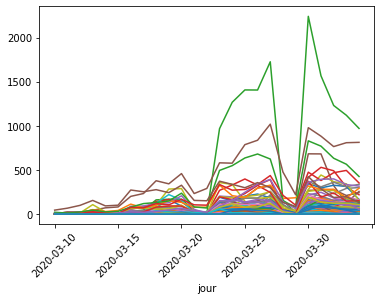

In [155]:
df = df.groupby(['dep','jour']).sum()
df.unstack(level=0)['nb_test'].plot(rot=45,legend=False)
plt.show()

In [168]:
file = wget.download('https://www.data.gouv.fr/fr/datasets/r/cc6d6e18-dde9-4f83-901d-725ba5e25879')

In [ ]:
pd.read_csv()

# Preliminary studies

# Learning task